In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [ ]:
if IN_COLAB:
    !pip install "top2vec[sentence_encoders]"
    !pip install "umap-learn[plot]"
    !pip install unidecode
    !pip install word2number
    !pip install contractions
    !python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 92.0 MB/s eta 0:00:00
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039187 sha256=4dd6f94aa5a505d12d5a9b65ad01f4c01f88365f8211fc3da2f1ca833b8c67da
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.w

In [ ]:
import os

if IN_COLAB:
    root_path = '/content/drive/Othercomputers/My MacBook Pro/HawaiiNewsAndTweets'
    os.chdir(root_path)
else:
    root_path = os.getcwd()
    os.chdir(root_path)

In [ ]:
import sys
if IN_COLAB:
    sys.path.append('../')
else:
    sys.path.append('../../')
from Top2VecDT.preprocessing import preprocess
from Top2VecDT.top2vec_custom import Top2Vec

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

import umap
import umap.plot
import tensorflow as tf
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

if tf.config.list_physical_devices(device_type='GPU') != []:
    print('GPU Detected')
else:
    print('GPU Not Detected')

GPU Detected


In [ ]:
df = pd.read_csv('./data/HawaiiFires-1 - Sep 14, 2023 - 8 10 18 PM.csv')

# Check if source is not twitter
assert ['Twitter'] == df['Source'].unique()

# Check if language is only english
df = df[df['Language']=='English']
assert df['Language'].unique() == ['English']

# Preprocess Data
df_new = preprocess(df, 'Hit Sentence')

2023-09-19 08:11:24,880 - preprocessing - INFO - Starting preprocess
INFO:preprocessing:Starting preprocess
2023-09-19 08:11:24,882 - preprocessing - INFO - Replacing N-grams...
INFO:preprocessing:Replacing N-grams...
2023-09-19 08:12:17,461 - preprocessing - INFO - General Preprocessing...
INFO:preprocessing:General Preprocessing...


In [ ]:
df_new = df_new[['Date', 'Tweet Id', 'Twitter Id', 'Hit Sentence', 'Initial_conv_preprocessed']]
df_new.head()

Date               Tweet Id   Twitter Id  \
0  14-Sep-2023 09:00AM  "1702351505406267796"  "174793500"   
1  14-Sep-2023 08:54AM  "1702350117293199823"   "21353830"   
2  14-Sep-2023 08:38AM  "1702345985614283055"  "538350190"   
3  14-Sep-2023 08:35AM  "1702345254056190113"  "564111558"   
4  14-Sep-2023 08:33AM  "1702344718351282457"   "34713362"   

                                        Hit Sentence  \
0  “We are lucky we didn’t lose dozens of fire fi...   
1  Fundraiser by Trevor Martin : The fire in Laha...   
2  I just watched a Maui fire survivor who said p...   
3  Hawaiian Electric’s CEO has been asked to test...   
4  Hawaiian Electric’s CEO has been asked to test...   

                           Initial_conv_preprocessed  
0             lucky lose dozen fighter tell mauifire  
1                     fundraiser   hi- etrata family  
2  watch survivor people literally burn street fl...  
3  hawaiian electric ceo testify house committee ...  
4  hawaiian electric ceo testify house committee ...

In [ ]:
df_new.to_csv("./data/hawaii_fire_tweets.csv", index=False)

# Iterations

In [ ]:
# Load df and convert to document list
df_new = pd.read_csv("./data/hawaii_fire_tweets.csv")
df_new.dropna(inplace=True)

docs = [str(i) for i in df_new['Initial_conv_preprocessed'].tolist()]

In [ ]:
n# Testing multiple iteration of algorithm

testing_df = pd.DataFrame(columns = ['Iteration Number', 'Cluster Size', 'Sample size', 'neighbors', 'components', 'min_dist',
                                 'Silhouette score', 'Number of Topics', 'Topic Distribution', 'Topic_words'])
testing_df.to_excel('./outputs/hawaii_fire_twitter_output.xlsx', index=False)

testing_df_index = 0
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

mcs_list = [0.025, 0.005, 0.01]
for iter_no in range(1): # Multiple iterations of same parameter combinations
    for idex, mcs_ in enumerate(mcs_list): # min_cluster_size
        for ms_ in [0.1, 0.25, 0.5, 0.75]: # min_samples
            for n_neig in [3, 5]:
                for n_comp in [3, 5]:
                    for mini_dist in [0.25, 0.1]:
                        mcs = int(mcs_ * len(docs))
                        ms = int(ms_ * mcs)
                        print('Try: ', iter_no, mcs, ms, n_neig, n_comp, mini_dist)
                        try:
                            print("Model Start")
                            model_all = Top2Vec(documents= docs,
                                                speed='fast-learn', workers=8,
                                                embedding_model='universal-sentence-encoder-large',
                                                dataset_type = 'hawaii_fires_twitter_embedding',
                                                use_cached = True,
                                                min_count = 5, # Ignore words whose freq is lower than this
                                                umap_args={'n_neighbors': n_neig,
                                                           'n_components': n_comp,
                                                           'metric':'wminkowski',
                                                           'min_dist':mini_dist,
                                                           'random_state':42
                                                           },
                                                args={'min_cluster_size':mcs, # Number of points to be called a cluster
                                                      'min_samples':ms, # Control noise labelling
                                                      'cluster_selection_method':'leaf',
                                                      'prediction_data': True
                                                      },
                                                clustering_model='hdbscan')
                            print("Model End")
                            print()

                            topic_sizes, topic_nums = model_all.get_topic_sizes()
                            print(topic_sizes, topic_nums)

                            sil_score = silhouette_score(model_all.umap_cls.embedding_, model_all.cluster_cls.labels_)
                            print("Silhoeutte Score: ",sil_score)
                            print("Index: ",testing_df_index)

                            testing_df_index = testing_df_index + 1

                            topic_size_list = topic_sizes.tolist()
                            topic_size_string = ', '.join(str(num) for num in topic_size_list)

                            topic_words, word_scores, topic_nums = model_all.get_topics()
                            my_list = []

                            for i in range(model_all.get_num_topics()):
                                my_list.append((topic_words[i][:10]))

                            testing_df.loc[testing_df_index, 'Iteration Number'] = iter_no
                            testing_df.loc[testing_df_index, 'Cluster Size'] = mcs
                            testing_df.loc[testing_df_index, 'Sample size'] = ms
                            testing_df.loc[testing_df_index, 'neighbors'] = n_neig
                            testing_df.loc[testing_df_index, 'components'] = n_comp
                            testing_df.loc[testing_df_index, 'min_dist'] = mini_dist
                            testing_df.loc[testing_df_index, 'Silhouette score'] = sil_score
                            testing_df.loc[testing_df_index, 'Number of Topics'] = model_all.get_num_topics()
                            testing_df.loc[testing_df_index, 'Clustering Algorithm used'] = 'HDBSCAN'
                            testing_df.loc[testing_df_index, 'Topic Distribution'] = topic_size_string
                            testing_df.loc[testing_df_index, 'Topic_words'] = str(my_list)

                            testing_df.to_excel('./outputs/hawaii_fire_twitter_output.xlsx', index=False)
                            print(testing_df.iloc[-1])
                        except Exception as e:
                            print('Error: ' , e)
                            continue
                    print("\n=====================================\n")

2023-09-19 08:28:32,170 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 46 3 3 0.25
Model Start


2023-09-19 08:28:38,479 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f370844b160>
No cache exists! Creating a new cache


2023-09-19 08:28:40,686 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-09-19 08:28:53,701 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:28:55,354 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 46 3 3 0.1
Model Start


2023-09-19 08:29:00,919 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c06d53f0>


2023-09-19 08:29:01,314 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:29:15,524 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:29:16,163 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Error:  Input contains NaN.


Try:  0 461 46 3 5 0.25
Model Start


2023-09-19 08:29:21,507 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce3934c0>


2023-09-19 08:29:21,907 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:29:33,417 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.
Try:  0 461 46 3 5 0.1
Model Start


2023-09-19 08:29:34,326 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-09-19 08:29:39,601 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d30bb2e0>


2023-09-19 08:29:39,989 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:29:52,676 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:29:53,365 - top2vec - INFO - Pre-processing documents for training


Error:  Input contains NaN.


Try:  0 461 46 5 3 0.25
Model Start


INFO:top2vec:Pre-processing documents for training
2023-09-19 08:29:58,586 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c07fac50>


2023-09-19 08:29:58,974 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:30:13,715 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:30:14,323 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:30:14,352 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:30:18,981 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.07595849
Index:  0
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.075958
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 1, dtype: object
Try:  0 461 46 5 3 0.1
Model Start


2023-09-19 08:30:24,150 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d325c760>


2023-09-19 08:30:24,533 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:30:39,664 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:30:40,177 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:30:40,194 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:30:44,915 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.17811377
Index:  1
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.178114
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 2, dtype: object


Try:  0 461 46 5 5 0.25
Model Start


2023-09-19 08:30:50,208 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2b2b580>


2023-09-19 08:30:50,598 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:31:03,681 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:31:04,403 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:31:04,417 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:31:08,874 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.03155978
Index:  2
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                       0.03156
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 3, dtype: object
Try:  0 461 46 5 5 0.1
Model Start


2023-09-19 08:31:14,174 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690f0f130>


2023-09-19 08:31:14,553 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:31:27,934 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:31:28,552 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:31:28,570 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:31:33,031 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.13626005
Index:  3
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                       0.13626
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 4, dtype: object


Try:  0 461 115 3 3 0.25
Model Start


2023-09-19 08:31:38,500 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3708449db0>


2023-09-19 08:31:38,899 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:31:50,998 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:31:51,858 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 115 3 3 0.1
Model Start


2023-09-19 08:31:57,104 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3708586b00>


2023-09-19 08:31:57,500 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:32:11,866 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:32:12,636 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 115 3 5 0.25
Model Start


2023-09-19 08:32:17,961 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d33e6ce0>


2023-09-19 08:32:18,363 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:32:29,774 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:32:30,876 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 115 3 5 0.1
Model Start


2023-09-19 08:32:36,226 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d34c8640>


2023-09-19 08:32:36,615 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:32:49,254 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:32:50,125 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 115 5 3 0.25
Model Start


2023-09-19 08:32:55,360 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2e7e4d0>


2023-09-19 08:32:55,737 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:33:10,450 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:33:11,349 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:33:11,363 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:33:16,200 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.11125373
Index:  4
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                115
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.111254
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 5, dtype: object
Try:  0 461 115 5 3 0.1
Model Start


2023-09-19 08:33:21,392 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce485570>


2023-09-19 08:33:21,787 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:33:36,571 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:33:37,412 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:33:37,428 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:33:42,217 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.03763561
Index:  5
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                115
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.037636
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 6, dtype: object


Try:  0 461 115 5 5 0.25
Model Start


2023-09-19 08:33:47,472 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690ceff40>


2023-09-19 08:33:47,857 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:34:01,235 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:34:02,433 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:34:02,446 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:34:07,028 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.032994773
Index:  6
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                115
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.032995
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 7, dtype: object
Try:  0 461 115 5 5 0.1
Model Start


2023-09-19 08:34:12,425 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c046ce50>


2023-09-19 08:34:12,812 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:34:26,216 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:34:27,243 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:34:27,261 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:34:31,793 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.06588975
Index:  7
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                115
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                       0.06589
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 8, dtype: object


Try:  0 461 230 3 3 0.25
Model Start


2023-09-19 08:34:37,199 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d35a7bb0>


2023-09-19 08:34:37,584 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:34:50,102 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:34:51,115 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 230 3 3 0.1
Model Start


2023-09-19 08:34:56,384 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d3711d80>


2023-09-19 08:34:56,765 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:35:10,424 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:35:11,398 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 230 3 5 0.25
Model Start


2023-09-19 08:35:16,751 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c08b11b0>


2023-09-19 08:35:17,143 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:35:28,360 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:35:29,543 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Error:  Input contains NaN.
Try:  0 461 230 3 5 0.1
Model Start


2023-09-19 08:35:36,168 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36909d2020>


2023-09-19 08:35:36,560 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:35:49,065 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:35:50,167 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 230 5 3 0.25
Model Start


2023-09-19 08:35:55,506 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36909e69b0>


2023-09-19 08:35:55,910 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:36:10,237 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:36:11,918 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:36:11,930 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:36:16,793 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.20166834
Index:  8
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                230
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.201668
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 9, dtype: object
Try:  0 461 230 5 3 0.1
Model Start


2023-09-19 08:36:22,002 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2c49cf0>


2023-09-19 08:36:22,404 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:36:36,332 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:36:37,838 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:36:37,851 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:36:42,536 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.062281154
Index:  9
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                230
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                     -0.062281
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 10, dtype: object


Try:  0 461 230 5 5 0.25
Model Start


2023-09-19 08:36:47,871 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce11a860>


2023-09-19 08:36:48,267 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:37:01,440 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:37:03,451 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:37:03,463 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:37:08,414 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.13942222
Index:  10
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                230
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.139422
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 11, dtype: object
Try:  0 461 230 5 5 0.1
Model Start


2023-09-19 08:37:14,876 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f38ff798ca0>


2023-09-19 08:37:15,292 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:37:28,856 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:37:30,697 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:37:30,712 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:37:35,766 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.056293882
Index:  11
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                230
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                     -0.056294
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 12, dtype: object


Try:  0 461 345 3 3 0.25
Model Start


2023-09-19 08:37:41,270 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2b63940>


2023-09-19 08:37:41,692 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:37:55,934 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:37:57,212 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 345 3 3 0.1
Model Start


2023-09-19 08:38:02,641 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c01a87c0>


2023-09-19 08:38:03,029 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:38:15,901 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:38:17,123 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 345 3 5 0.25
Model Start


2023-09-19 08:38:22,577 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c63c9540>


2023-09-19 08:38:22,986 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:38:35,741 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:38:37,306 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 461 345 3 5 0.1
Model Start


2023-09-19 08:38:43,924 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d34dfdc0>


2023-09-19 08:38:44,331 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:38:56,200 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:38:57,677 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 461 345 5 3 0.25
Model Start


2023-09-19 08:39:03,194 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c09dedd0>


2023-09-19 08:39:03,601 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:39:19,169 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:39:21,390 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:39:21,401 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:39:26,747 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.15907471
Index:  12
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                345
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.159075
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 13, dtype: object
Try:  0 461 345 5 3 0.1
Model Start


2023-09-19 08:39:32,242 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d3158430>


2023-09-19 08:39:32,662 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:39:47,948 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:39:50,081 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:39:50,093 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:39:55,487 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.15118824
Index:  13
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                345
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                     -0.151188
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 14, dtype: object


Try:  0 461 345 5 5 0.25
Model Start


2023-09-19 08:40:01,064 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0932200>


2023-09-19 08:40:01,454 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:40:15,683 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:40:18,601 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:40:18,612 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:40:23,955 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.13769923
Index:  14
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                345
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.137699
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 15, dtype: object
Try:  0 461 345 5 5 0.1
Model Start


2023-09-19 08:40:30,565 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce484fa0>


2023-09-19 08:40:30,955 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:40:45,579 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:40:48,217 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:40:48,232 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:40:53,409 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.05379902
Index:  15
Iteration Number                                                             0
Cluster Size                                                               461
Sample size                                                                345
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                     -0.053799
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 16, dtype: object


Try:  0 92 9 3 3 0.25
Model Start


2023-09-19 08:40:58,954 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0ff2da0>


2023-09-19 08:40:59,356 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:41:13,775 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:41:14,500 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 9 3 3 0.1
Model Start


2023-09-19 08:41:20,201 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d317ccd0>


2023-09-19 08:41:20,620 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:41:33,550 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:41:34,262 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 9 3 5 0.25
Model Start


2023-09-19 08:41:39,882 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3708448e50>


2023-09-19 08:41:40,295 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:41:52,898 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:41:53,676 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 9 3 5 0.1
Model Start


2023-09-19 08:42:00,343 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2d67190>


2023-09-19 08:42:00,753 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:42:13,154 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:42:13,906 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 9 5 3 0.25
Model Start


2023-09-19 08:42:19,664 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c031bc70>


2023-09-19 08:42:20,063 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:42:35,543 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:42:35,939 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:42:35,959 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:42:40,606 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.14717463
Index:  16
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                  9
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                      0.147175
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 17, dtype: object
Try:  0 92 9 5 3 0.1
Model Start


2023-09-19 08:42:46,161 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f369085e3b0>


2023-09-19 08:42:46,569 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:43:01,437 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:43:01,816 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:43:01,835 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:43:06,488 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.21500628
Index:  17
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                  9
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.215006
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 18, dtype: object


Try:  0 92 9 5 5 0.25
Model Start


2023-09-19 08:43:12,064 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce2209d0>


2023-09-19 08:43:12,464 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:43:26,199 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:43:26,697 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:43:26,721 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:43:31,304 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.23261583
Index:  18
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                  9
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                      0.232616
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 19, dtype: object
Try:  0 92 9 5 5 0.1
Model Start


2023-09-19 08:43:36,896 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c01eaa40>


2023-09-19 08:43:37,306 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:43:50,122 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:43:50,555 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:43:50,579 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:43:55,132 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.3161483
Index:  19
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                  9
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                      0.316148
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 20, dtype: object


Try:  0 92 23 3 3 0.25
Model Start


2023-09-19 08:44:00,753 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0524910>


2023-09-19 08:44:01,164 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:44:14,484 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:44:15,260 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 23 3 3 0.1
Model Start


2023-09-19 08:44:20,819 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690fb1d50>


2023-09-19 08:44:21,218 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:44:34,464 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:44:35,163 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 23 3 5 0.25
Model Start


2023-09-19 08:44:40,615 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3719a4b4f0>


2023-09-19 08:44:41,002 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:44:54,877 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:44:55,689 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 23 3 5 0.1
Model Start


2023-09-19 08:45:01,189 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3719a4b100>


2023-09-19 08:45:01,575 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:45:13,062 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:45:13,822 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 23 5 3 0.25
Model Start


2023-09-19 08:45:19,405 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c62e51b0>


2023-09-19 08:45:19,804 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:45:35,095 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:45:35,548 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:45:35,569 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:45:40,372 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.028463362
Index:  20
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 23
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                      0.028463
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 21, dtype: object
Try:  0 92 23 5 3 0.1
Model Start


2023-09-19 08:45:45,727 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d3783940>


2023-09-19 08:45:46,118 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:46:01,201 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:46:01,634 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:46:01,654 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:46:06,153 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.1709027
Index:  21
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 23
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.170903
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 22, dtype: object


Try:  0 92 23 5 5 0.25
Model Start


2023-09-19 08:46:11,639 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2d658d0>


2023-09-19 08:46:12,026 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:46:25,902 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:46:26,489 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:46:26,511 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:46:31,024 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.12455894
Index:  22
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 23
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                      0.124559
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 23, dtype: object
Try:  0 92 23 5 5 0.1
Model Start


2023-09-19 08:46:36,565 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f371023ec20>


2023-09-19 08:46:36,963 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:46:49,623 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:46:50,137 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:46:50,159 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:46:54,751 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.24297982
Index:  23
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 23
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                       0.24298
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 24, dtype: object


Try:  0 92 46 3 3 0.25
Model Start


2023-09-19 08:47:00,340 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36908349a0>


2023-09-19 08:47:00,736 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:47:13,507 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:47:14,267 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 46 3 3 0.1
Model Start


2023-09-19 08:47:19,735 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f37194de2c0>


2023-09-19 08:47:20,168 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:47:33,651 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:47:34,392 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 46 3 5 0.25
Model Start


2023-09-19 08:47:39,795 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0965810>


2023-09-19 08:47:40,193 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:47:53,535 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:47:54,463 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 46 3 5 0.1
Model Start


2023-09-19 08:47:59,937 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3708537400>


2023-09-19 08:48:00,318 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:48:12,431 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:48:13,257 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 46 5 3 0.25
Model Start


2023-09-19 08:48:18,668 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce43add0>


2023-09-19 08:48:19,063 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:48:34,079 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:48:34,680 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:48:34,696 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:48:39,575 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.111412436
Index:  24
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.111412
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 25, dtype: object
Try:  0 92 46 5 3 0.1
Model Start


2023-09-19 08:48:44,890 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c02b76a0>


2023-09-19 08:48:45,286 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:49:00,239 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:49:00,749 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:49:00,767 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:49:05,471 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.0587485
Index:  25
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.058748
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 26, dtype: object


Try:  0 92 46 5 5 0.25
Model Start


2023-09-19 08:49:10,958 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c045c2b0>


2023-09-19 08:49:11,344 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:49:25,874 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:49:26,604 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:49:26,623 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:49:31,362 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.040759306
Index:  26
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.040759
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 27, dtype: object
Try:  0 92 46 5 5 0.1
Model Start


2023-09-19 08:49:36,909 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c6381930>


2023-09-19 08:49:37,312 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:49:50,134 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:49:50,756 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:49:50,775 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:49:55,412 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.12392827
Index:  27
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                      0.123928
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 28, dtype: object


Try:  0 92 69 3 3 0.25
Model Start


2023-09-19 08:50:00,882 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0af0250>


2023-09-19 08:50:01,268 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:50:13,805 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:50:14,614 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 69 3 3 0.1
Model Start


2023-09-19 08:50:20,055 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690d6b5b0>


2023-09-19 08:50:20,437 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:50:34,574 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:50:35,354 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 69 3 5 0.25
Model Start


2023-09-19 08:50:40,862 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f37084bc2b0>


2023-09-19 08:50:41,271 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:50:53,669 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:50:54,635 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 92 69 3 5 0.1
Model Start


2023-09-19 08:51:00,132 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36747556f0>


2023-09-19 08:51:00,530 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:51:13,473 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:51:14,326 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 92 69 5 3 0.25
Model Start


2023-09-19 08:51:19,808 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36909142b0>


2023-09-19 08:51:20,210 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:51:34,302 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:51:35,016 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:51:35,031 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:51:39,861 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.27570525
Index:  28
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 69
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.275705
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 29, dtype: object
Try:  0 92 69 5 3 0.1
Model Start


2023-09-19 08:51:45,200 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690c748b0>


2023-09-19 08:51:45,604 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:51:59,906 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:52:00,520 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:52:00,540 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:52:05,479 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.07191097
Index:  29
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 69
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                     -0.071911
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 30, dtype: object


Try:  0 92 69 5 5 0.25
Model Start


2023-09-19 08:52:10,898 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0b118a0>


2023-09-19 08:52:11,287 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:52:24,645 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:52:26,707 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:52:26,725 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:52:31,670 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.15617014
Index:  30
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 69
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                      -0.15617
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 31, dtype: object
Try:  0 92 69 5 5 0.1
Model Start


2023-09-19 08:52:37,246 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c06d4400>


2023-09-19 08:52:37,639 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:52:50,860 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:52:51,599 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:52:51,617 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:52:56,314 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.005937907
Index:  31
Iteration Number                                                             0
Cluster Size                                                                92
Sample size                                                                 69
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                      0.005938
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 32, dtype: object


Try:  0 184 18 3 3 0.25
Model Start


2023-09-19 08:53:01,884 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f371035b250>


2023-09-19 08:53:02,269 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:53:14,702 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:53:15,463 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 18 3 3 0.1
Model Start


2023-09-19 08:53:20,904 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f370859b4f0>


2023-09-19 08:53:21,295 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:53:35,091 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:53:35,814 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 18 3 5 0.25
Model Start


2023-09-19 08:53:41,265 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f369069f760>


2023-09-19 08:53:41,652 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:53:53,888 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:53:54,716 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 18 3 5 0.1
Model Start


2023-09-19 08:54:00,455 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d30f3850>


2023-09-19 08:54:00,846 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:54:13,779 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:54:14,536 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 18 5 3 0.25
Model Start


2023-09-19 08:54:20,025 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce1ef130>


2023-09-19 08:54:20,418 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:54:34,125 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:54:34,591 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:54:34,609 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:54:39,101 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.044566628
Index:  32
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 18
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                      0.044567
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 33, dtype: object
Try:  0 184 18 5 3 0.1
Model Start


2023-09-19 08:54:44,489 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c01a83a0>


2023-09-19 08:54:44,885 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:54:59,618 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:55:00,046 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:55:00,066 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:55:04,713 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.089685544
Index:  33
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 18
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.089686
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 34, dtype: object


Try:  0 184 18 5 5 0.25
Model Start


2023-09-19 08:55:10,122 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690c6cc10>


2023-09-19 08:55:10,514 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:55:24,325 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:55:25,987 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:55:26,007 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:55:30,871 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.14132594
Index:  34
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 18
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                      0.141326
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 35, dtype: object
Try:  0 184 18 5 5 0.1
Model Start


2023-09-19 08:55:36,581 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0b8e0e0>


2023-09-19 08:55:36,996 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:55:50,520 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:55:50,986 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:55:51,008 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:55:55,553 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.26519504
Index:  35
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 18
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                      0.265195
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 36, dtype: object


Try:  0 184 46 3 3 0.25
Model Start


2023-09-19 08:56:01,208 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f37085da710>


2023-09-19 08:56:01,601 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:56:14,374 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:56:15,189 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 46 3 3 0.1
Model Start


2023-09-19 08:56:20,744 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce0ca4a0>


2023-09-19 08:56:21,135 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:56:35,534 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:56:36,298 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 46 3 5 0.25
Model Start


2023-09-19 08:56:41,854 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c089d690>


2023-09-19 08:56:42,236 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:56:54,524 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:56:55,430 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 46 3 5 0.1
Model Start


2023-09-19 08:57:01,171 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d317d060>


2023-09-19 08:57:01,572 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:57:14,433 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:57:15,285 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 46 5 3 0.25
Model Start


2023-09-19 08:57:20,881 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690837cd0>


2023-09-19 08:57:21,283 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:57:35,243 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:57:35,790 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:57:35,807 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:57:40,581 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.14524212
Index:  36
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.145242
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 37, dtype: object
Try:  0 184 46 5 3 0.1
Model Start


2023-09-19 08:57:46,026 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36ce2d4760>


2023-09-19 08:57:46,436 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:58:00,481 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:58:00,999 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:58:01,017 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:58:05,663 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.06847589
Index:  37
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 46
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      0.068476
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 38, dtype: object


Try:  0 184 46 5 5 0.25
Model Start


2023-09-19 08:58:11,194 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d3107940>


2023-09-19 08:58:11,603 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:58:25,503 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:58:26,247 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:58:26,265 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:58:30,951 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.017057955
Index:  38
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.017058
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 39, dtype: object
Try:  0 184 46 5 5 0.1
Model Start


2023-09-19 08:58:36,706 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c63c40d0>


2023-09-19 08:58:37,138 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:58:50,366 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:58:51,041 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 08:58:51,058 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 08:58:55,776 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  0.073224775
Index:  39
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 46
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                      0.073225
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 40, dtype: object


Try:  0 184 92 3 3 0.25
Model Start


2023-09-19 08:59:01,429 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f370859bee0>


2023-09-19 08:59:01,837 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:59:15,732 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:59:16,637 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 92 3 3 0.1
Model Start


2023-09-19 08:59:22,196 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d31d6d40>


2023-09-19 08:59:22,586 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:59:35,686 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 08:59:36,191 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Error:  Input contains NaN.


Try:  0 184 92 3 5 0.25
Model Start


2023-09-19 08:59:42,044 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d2bad8a0>


2023-09-19 08:59:42,440 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 08:59:56,320 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 08:59:57,349 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 92 3 5 0.1
Model Start


2023-09-19 09:00:03,219 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c0ff0310>


2023-09-19 09:00:03,621 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:00:15,510 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 09:00:16,479 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 92 5 3 0.25
Model Start


2023-09-19 09:00:22,046 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c06ad1b0>


2023-09-19 09:00:22,434 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:00:37,606 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:00:38,396 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:00:38,410 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:00:43,582 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.27887124
Index:  40
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 92
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                     -0.278871
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 41, dtype: object
Try:  0 184 92 5 3 0.1
Model Start


2023-09-19 09:00:49,095 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f369085c580>


2023-09-19 09:00:49,488 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:01:04,618 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:01:05,407 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:01:05,424 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:01:10,484 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.08488011
Index:  41
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 92
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                      -0.08488
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 42, dtype: object


Try:  0 184 92 5 5 0.25
Model Start


2023-09-19 09:01:16,098 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c08210c0>


2023-09-19 09:01:16,490 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:01:31,030 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:01:32,077 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:01:32,093 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:01:37,025 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.13401194
Index:  42
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 92
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                     -0.134012
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 43, dtype: object
Try:  0 184 92 5 5 0.1
Model Start


2023-09-19 09:01:42,913 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c08fa1a0>


2023-09-19 09:01:43,327 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:01:56,705 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:01:57,587 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:01:57,604 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:02:02,421 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.05414774
Index:  43
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                 92
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                     -0.054148
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 44, dtype: object


Try:  0 184 138 3 3 0.25
Model Start


2023-09-19 09:02:08,158 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c644fee0>


2023-09-19 09:02:08,553 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:02:21,569 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 09:02:22,542 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 138 3 3 0.1
Model Start


2023-09-19 09:02:28,085 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36d31b2560>


2023-09-19 09:02:28,485 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:02:42,709 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 09:02:43,646 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-09-19 09:02:49,243 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding




Try:  0 184 138 3 5 0.25
Model Start
<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3674519930>


2023-09-19 09:02:49,640 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:03:02,329 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 09:03:03,478 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Try:  0 184 138 3 5 0.1
Model Start


2023-09-19 09:03:09,388 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c056cac0>


2023-09-19 09:03:09,801 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:03:22,748 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents


Error:  Input contains NaN.


2023-09-19 09:03:23,771 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training




Try:  0 184 138 5 3 0.25
Model Start


2023-09-19 09:03:29,477 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3690eaa890>


2023-09-19 09:03:29,891 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:03:44,762 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:03:45,765 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:03:45,776 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:03:50,817 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.28928024
Index:  44
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                138
neighbors                                                                    5
components                                                                   3
min_dist                                                                  0.25
Silhouette score                                                      -0.28928
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 45, dtype: object
Try:  0 184 138 5 3 0.1
Model Start


2023-09-19 09:03:56,515 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c073b0d0>


2023-09-19 09:03:56,946 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:04:11,465 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:04:12,425 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:04:12,439 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:04:17,193 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.13759537
Index:  45
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                138
neighbors                                                                    5
components                                                                   3
min_dist                                                                   0.1
Silhouette score                                                     -0.137595
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'fema', 'di...
Clustering Algorithm used                                              HDBSCAN
Name: 46, dtype: object


Try:  0 184 138 5 5 0.25
Model Start


2023-09-19 09:04:22,900 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3708480700>


2023-09-19 09:04:23,299 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:04:37,141 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:04:38,544 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:04:38,557 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]


2023-09-19 09:04:43,323 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Silhoeutte Score:  -0.1473497
Index:  46
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                138
neighbors                                                                    5
components                                                                   5
min_dist                                                                  0.25
Silhouette score                                                      -0.14735
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 47, dtype: object
Try:  0 184 138 5 5 0.1
Model Start


2023-09-19 09:04:49,296 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f36c6493a90>


2023-09-19 09:04:49,713 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_hawaii_fires_twitter_embedding.npy


2023-09-19 09:05:02,678 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-19 09:05:03,855 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-19 09:05:03,871 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


Model End

[18446] [0]
Silhoeutte Score:  -0.103089124
Index:  47
Iteration Number                                                             0
Cluster Size                                                               184
Sample size                                                                138
neighbors                                                                    5
components                                                                   5
min_dist                                                                   0.1
Silhouette score                                                     -0.103089
Number of Topics                                                             1
Topic Distribution                                                       18446
Topic_words                  [array(['evacuate', 'catastrophe', 'disaster',...
Clustering Algorithm used                                              HDBSCAN
Name: 48, dtype: object




##Test sample model

In [ ]:
model_all = Top2Vec(documents=[str(i) for i in df['Initial_conv_preprocessed'].tolist()], speed='fast-learn', workers=8,
                                          embedding_model='universal-sentence-encoder',
                                          dataset_type = 'all',
                                          use_cached = True,
                                          umap_args={'n_neighbors': 30,'n_components': 3,'metric': 'cosine','min_dist':0.25,'random_state':42},
                                          args={'min_cluster_size':100,'min_samples':75,'cluster_selection_method': 'leaf', 'prediction_data': True},
                                          clustering_model='hdbscan')

2023-08-17 19:26:58,115 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-08-17 19:27:06,844 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x785004551bd0>


2023-08-17 19:27:07,232 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder_all.npy


2023-08-17 19:27:40,953 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-08-17 19:27:41,496 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-08-17 19:27:41,508 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


In [ ]:
topic_sizes, topic_nums = model_all.get_topic_sizes()
print(topic_sizes, topic_nums)

sil_score = silhouette_score(model_all.umap_cls.embedding_, model_all.cluster_cls.labels_)
print("silscore: ",sil_score)

[3174 2813 1198  691  335] [0 1 2 3 4]
silscore:  -0.22529301


In [ ]:
topic_words, word_scores, topic_nums = model_all.get_topics()
print(tuple(model_all.doc_dist_all_ordered))
print(model_all.doc_dist)
print(str(tuple(topic_words)))
print(str(tuple(topic_words[0])))
print(str(tuple(topic_words[1])))

({4: 0.39232233, 3: 0.3977635, 1: 0.39396673, 2: 0.4838376, 0: 0.5935457}, {4: 0.116883114, 3: 0.1655314, 1: 0.37796497, 2: 0.29036763, 0: 0.2143513}, {4: 0.13803667, 3: 0.36846635, 1: 0.35168552, 2: 0.24831328, 0: 0.3156113}, {4: 0.29942754, 3: 0.32576782, 1: 0.3422941, 2: 0.39773208, 0: 0.54600513}, {4: 0.09076956, 3: 0.08397323, 1: 0.25210345, 2: 0.22595653, 0: 0.21311891}, {4: 0.36477607, 3: 0.26222032, 1: 0.26574644, 2: 0.35837206, 0: 0.42659506}, {4: 0.14841431, 3: 0.31474262, 1: 0.32265586, 2: 0.21566918, 0: 0.27807468}, {4: 0.45149755, 3: 0.34741068, 1: 0.4143707, 2: 0.48243818, 0: 0.6165871}, {4: 0.25090408, 3: 0.38924342, 1: 0.34564656, 2: 0.33409876, 0: 0.38373485}, {4: 0.41024855, 3: 0.3584661, 1: 0.40957034, 2: 0.4589861, 0: 0.62350535}, {4: 0.15923154, 3: 0.13225543, 1: 0.10629252, 2: 0.33166546, 0: 0.28349417}, {4: 0.07424537, 3: 0.24367636, 1: 0.28094834, 2: 0.07815692, 0: 0.14718051}, {4: 0.14785278, 3: 0.26331913, 1: 0.22769508, 2: 0.25868496, 0: 0.29346684}, {4: 0.41

In [ ]:
#testing_df.to_excel('testing_df.xlsx', index=False)

##Sample model

In [ ]:
model_all = Top2Vec(documents=[str(i) for i in df['Initial_conv_preprocessed'].tolist()], speed='fast-learn', workers=8,
                                          embedding_model='universal-sentence-encoder',
                                          dataset_type = 'all',
                                          use_cached = True,
                                          umap_args={'n_neighbors': 30,'n_components': 3,'metric': 'cosine','min_dist':0.25,'random_state':42},
                                          args={'min_cluster_size':250,'min_samples':186,'cluster_selection_method': 'leaf', 'prediction_data': True},
                                          clustering_model='hdbscan')

2023-08-17 07:52:53,038 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-08-17 07:53:00,850 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7af3baeed660>


2023-08-17 07:53:01,324 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder_all.npy


2023-08-17 07:53:26,453 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-08-17 07:53:27,569 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-08-17 07:53:27,592 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


In [ ]:
topic_sizes, topic_nums = model_all.get_topic_sizes()
print(topic_sizes, topic_nums)
sil_score = silhouette_score(model_all.umap_cls.embedding_, model_all.cluster_cls.labels_)
print(sil_score)
print(model_all.get_num_topics())
print(tuple(topic_sizes))

[4156 4059] [0 1]
-0.095200725
2
(4156, 4059)


##Results of the above model if required

In [ ]:
word_count = 15

topic_words, word_scores, topic_nums = model_all.get_topics()
res_df = pd.DataFrame(columns = ['Document', 'Topic', 'Score', 'Words - Freq','All_topics'])
res_df['Document'] = df.Initial_conv_preprocessed.tolist()
res_df['Topic'] = model_all.doc_top
res_df['Score'] = model_all.doc_dist
res_df['All_topics'] = tuple(model_all.doc_dist_all_ordered)

for i, row in res_df.iterrows():
    print(f"Document: {i}", end='\r', flush=True)
    top = res_df.loc[i, :]['Topic']
    res_df.loc[i, 'Words - Freq'] =  str(tuple(topic_words[top][:word_count]))

res_df

Document  Topic     Score  \
0     hawaii  wildfire death toll rise focus shift s...      1  0.788891   
1     heart break lahaina happy green leaf sprout ba...      0  0.458369   
2     hey cougar nation maui fire devastating reside...      0  0.671323   
3     climate change man disaster destroy community ...      1  0.562017   
4     believe mainly impact lahaina area north ish w...      0  0.346183   
...                                                 ...    ...       ...   
8210     lahaina burn ground   ukraine dc care american      1  0.420756   
8211                                       lahaina fire      1  0.482306   
8212  wow lahaina church stand miraculously untouche...      0  0.747970   
8213  lahaina church miraculously untouched devastat...      0  0.734962   
8214  help homie & fam goal fundraiser   help   fami...      0  0.447250   

                                           Words - Freq  \
0     ('maui', 'wildfires', 'aloha', 'hawaii', 'laha...   
1     ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   
2     ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   
3     ('maui', 'wildfires', 'aloha', 'hawaii', 'laha...   
4     ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   
...                                                 ...   
8210  ('maui', 'wildfires', 'aloha', 'hawaii', 'laha...   
8211  ('maui', 'wildfires', 'aloha', 'hawaii', 'laha...   
8212  ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   
8213  ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   
8214  ('maui', 'lahaina', 'aloha', 'hawai', 'hawaiia...   

                          All_topics  
0       {0: 0.7353758, 1: 0.7888912}  
1      {0: 0.4583693, 1: 0.38545746}  
2        {0: 0.671323, 1: 0.5763285}  
3       {0: 0.4660892, 1: 0.5620172}  
4     {0: 0.34618288, 1: 0.32008433}  
...                              ...  
8210  {0: 0.36702427, 1: 0.42075604}  
8211  {0: 0.44856322, 1: 0.48230624}  
8212    {0: 0.7479704, 1: 0.6957898}  
8213      {0: 0.734962, 1: 0.691576}  
8214   {0: 0.4472497, 1: 0.35547674}  

[8215 rows x 5 columns]

In [ ]:
res_df.to_excel('res_df_low_sil_score.xlsx', index=False)

# Top2Vec - DryRun

In [ ]:
docs = [str(i) for i in df['Initial_conv_preprocessed'].tolist()]

In [ ]:
docs_new = []
for i in docs:
    sent = i.replace('like', '')
    docs_new.append(sent)

In [ ]:
model_all = Top2Vec(documents= docs*4,
                    speed='fast-learn', workers=8,
                    embedding_model='universal-sentence-encoder-large',
                    dataset_type = 'mult4',
                    use_cached = True,
                    min_count = 5, # Ignore words whose freq is lower than this
                    umap_args={'n_neighbors': 20,
                               'n_components': 30,
                               'metric':'wminkowski',
                               'min_dist':0.8,
                               'random_state':42},
                    args={'min_cluster_size':15, # Number of points to be called a cluster
                          'min_samples':10, # Control noise labelling
                          'cluster_selection_method':'leaf',
                          'prediction_data': True},
                    clustering_model='hdbscan')


topic_sizes, topic_nums = model_all.get_topic_sizes()
print(topic_sizes, topic_nums)

sil_score = silhouette_score(model_all.umap_cls.embedding_, model_all.cluster_cls.labels_)

print("Silhouette Score: ",sil_score)
print("Num topics: ", model_all.get_num_topics())

topic_words, word_scores, topic_nums = model_all.get_topics()

my_list = []
my_new_df = pd.DataFrame(columns = ['topic_number','topic_words'])

for i in range(model_all.get_num_topics()):
    my_list.append((topic_words[i][:10]))
    my_new_df.loc[i, 'topic_words'] = (topic_words[i][:10])

print(str(my_list))

2023-09-01 10:40:32,040 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-09-01 10:40:36,813 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7d6a36e55c60>


2023-09-01 10:40:37,141 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_mult4.npy


2023-09-01 10:41:09,441 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-01 10:41:09,592 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-01 10:41:09,597 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


[716 536] [0 1]
Silhouette Score:  -0.22668238
Num topics:  2
[array(['remove', 'delete', 'denier', 'leave', 'lose', 'alarmist',
       'destroy', 'abandon', 'fix', 'warming'], dtype='<U13'), array(['remove', 'delete', 'warming', 'alarmist', 'denier',
       'anthropogenic', 'collapse', 'disaster', 'climate', 'destroy'],
      dtype='<U13')]


In [ ]:
model_all = Top2Vec(documents= docs*4,
                    speed='fast-learn', workers=8,
                    embedding_model='universal-sentence-encoder-large',
                    dataset_type = 'mult4',
                    use_cached = True,
                    min_count = 3, # Ignore words whose freq is lower than this
                    umap_args={'n_neighbors': 20,
                               'n_components': 30,
                               'metric':'wminkowski',
                               'min_dist':0.8,
                               'random_state':42},
                    args={'min_cluster_size':50, # Number of points to be called a cluster
                          'min_samples':10, # Control noise labelling
                          'cluster_selection_method':'leaf',
                          'prediction_data': True},
                    clustering_model='hdbscan')


topic_sizes, topic_nums = model_all.get_topic_sizes()
print(topic_sizes, topic_nums)

sil_score = silhouette_score(model_all.umap_cls.embedding_, model_all.cluster_cls.labels_)

print("Silhouette Score: ",sil_score)
print("Num topics: ", model_all.get_num_topics())

topic_words, word_scores, topic_nums = model_all.get_topics()

my_list = []
my_new_df = pd.DataFrame(columns = ['topic_number','topic_words'])

for i in range(model_all.get_num_topics()):
    my_list.append((topic_words[i][:10]))
    my_new_df.loc[i, 'topic_words'] = (topic_words[i][:10])

print(str(my_list))

2023-09-01 10:44:17,036 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-09-01 10:44:21,720 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7d6a28a97d60>


2023-09-01 10:44:22,051 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents


Loading file from ./embedding_cache/universal-sentence-encoder-large_mult4.npy


2023-09-01 10:44:54,531 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-09-01 10:44:54,688 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2023-09-01 10:44:54,694 - top2vec - INFO - cosine_similarity
INFO:top2vec:cosine_similarity


[1252] [0]
Silhouette Score:  -0.025651844
Num topics:  1
[array(['remove', 'alarmist', 'denier', 'delete', 'denialist', 'drop',
       'anthropogenic', 'warming', 'asshole', 'catastrophic'],
      dtype='<U13')]


### Visuals

In [ ]:
# my_new_df.to_excel('53topics.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt
from itertools import combinations

In [ ]:
my_cmap = plt.get_cmap('hsv')

fig, axs = plt.subplots(5, 2, figsize=(16,16))

plot_no_x = 0
plot_no_y = 0

for comb in combinations([0, 1, 2, 3, 4], 2):
    axs[plot_no_x, plot_no_y].scatter(model_all.umap_cls.embedding_[:, comb[0]], model_all.umap_cls.embedding_[:, comb[1]], c=model_all.doc_top)
#     axs[plot_no_x, plot_no_y].set_xlim(5, 15)
#     axs[plot_no_x, plot_no_y].set_ylim(5, 15)
    plot_no_x+=1
    if plot_no_x == 5:
        plot_no_y+=1
        plot_no_x = 0
plt.show()

In [ ]:
model_all
attributes = dir(model_all)
print(attributes)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_assign_documents_to_topic', '_calculate_documents_topic', '_calculate_topic_sizes', '_check_document_index_status', '_check_hnswlib_status', '_check_import_status', '_check_model_status', '_check_word_index_status', '_create_topic_vectors', '_deduplicate_topics', '_embed_documents', '_find_topic_words_and_scores', '_get_combined_vec', '_get_document_ids', '_get_document_indexes', '_get_document_vectors', '_get_document_vectors_test', '_get_word_vectors', '_index2word', '_l2_normalize', '_less_than_zero', '_reorder_topics', '_reorder_topics_pred', '_search_vectors_by_vector', '_set_document_vectors', '_unassign_documents_from_topic', '_validate_d

In [ ]:
!pip install umap-learn[plot]

In [ ]:
import umap
import umap.plot

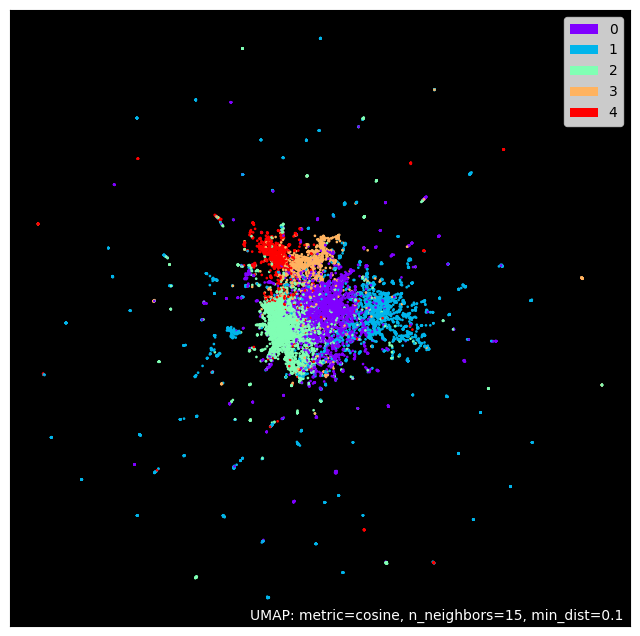

In [ ]:
umap_args={'n_neighbors': 15,'n_components': 2,'metric': 'cosine','min_dist':0.1,'random_state':42}
umap_model = umap.UMAP(**umap_args).fit(model_all._get_document_vectors(norm=False))
umap_fig1 = umap.plot.points(umap_model, labels = model_all.doc_top, theme='fire')

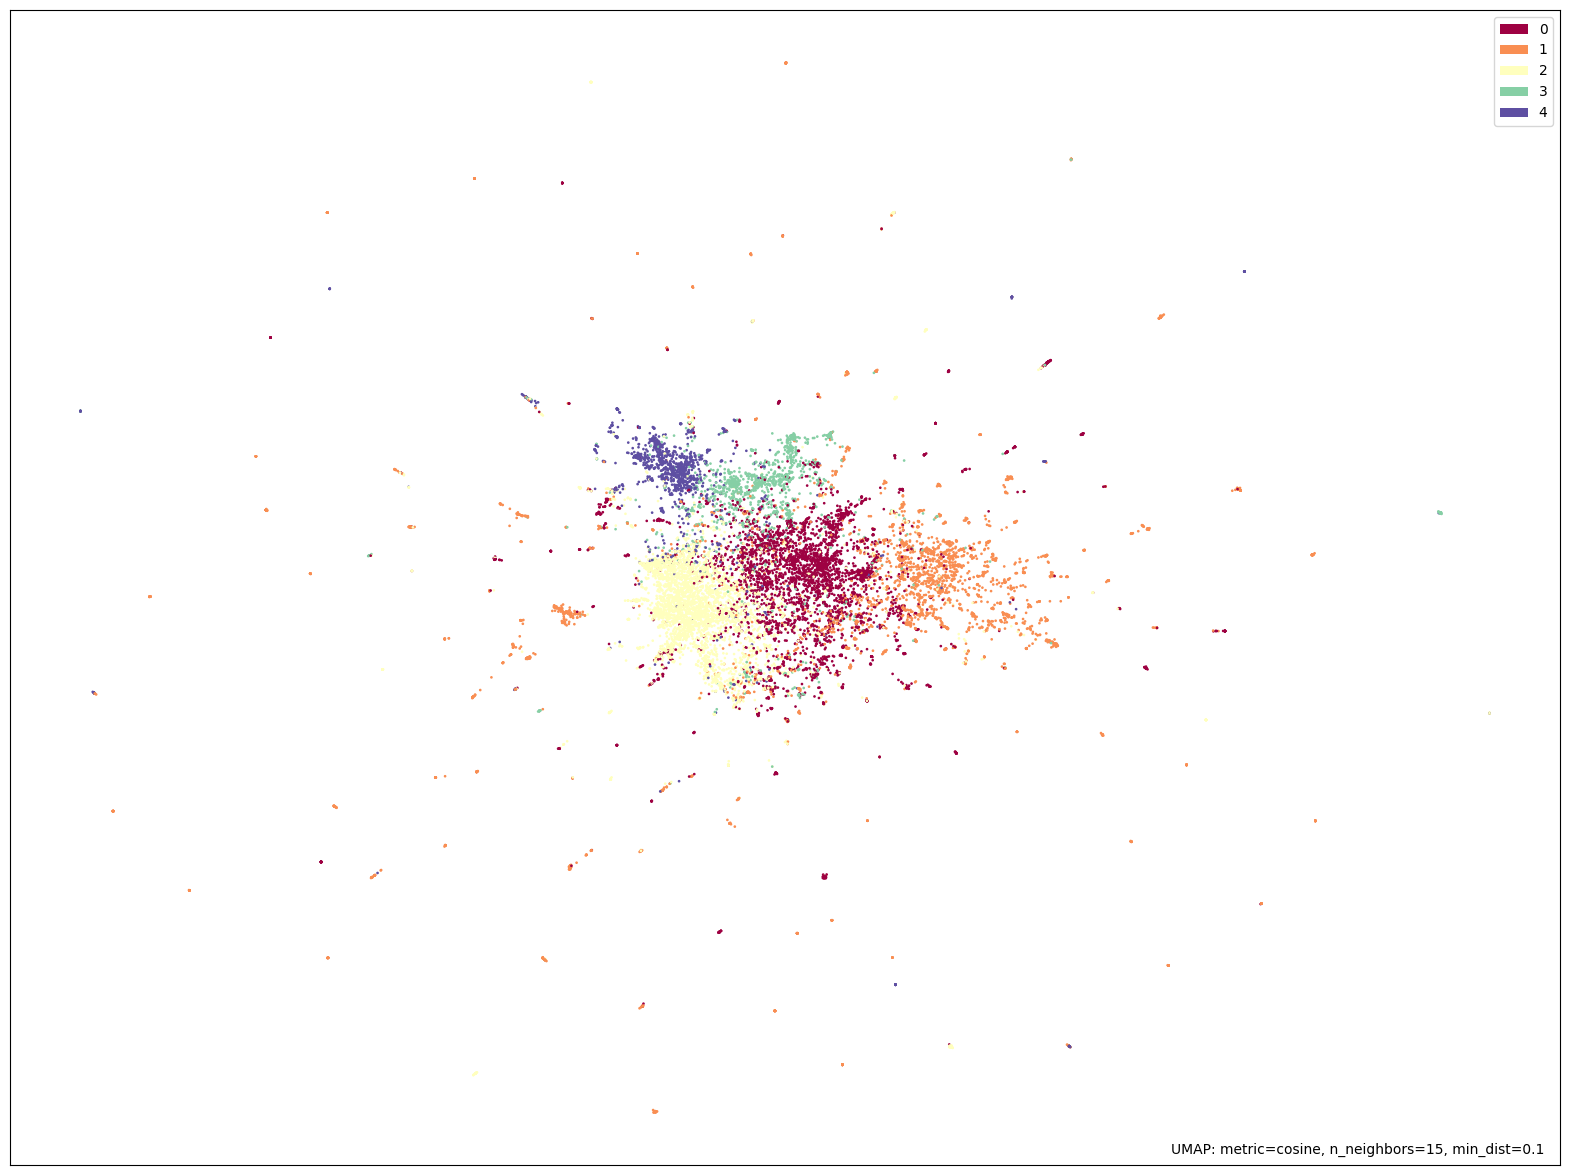

In [ ]:
umap_fig2 = umap.plot.points(
    umap_model,
    labels= model_all.doc_top,
    width=2000,
    height=1500,
)

In [ ]:
umap_args = {'n_neighbors': 30,'n_components': 2,'metric': 'cosine','min_dist':0.1,'random_state':42}

# Step 1: UMAP projection
umap_model = umap.UMAP(**umap_args).fit(model_all._get_document_vectors(norm=False))
umap_embedding = umap_model.transform(model_all._get_document_vectors(norm=False))


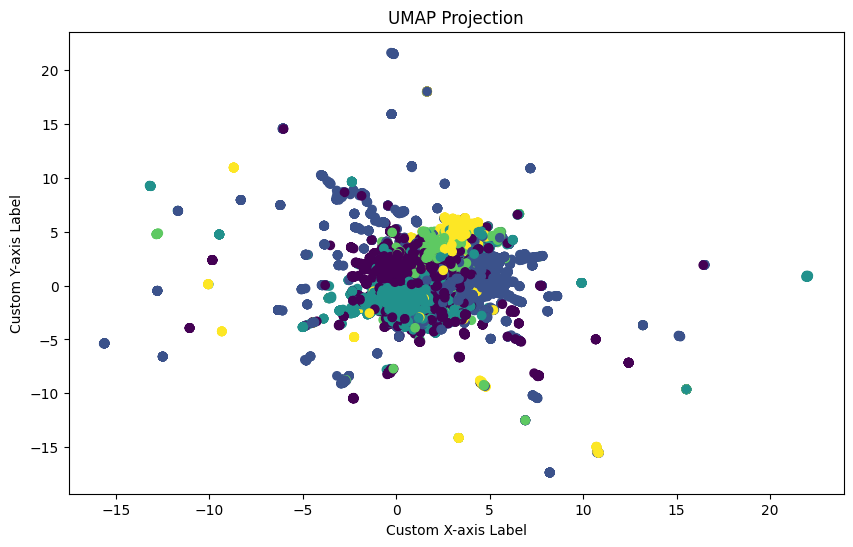

In [ ]:
# Create a scatter plot with custom x-axis and y-axis labels
plt.figure(figsize=(10, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=model_all.doc_top)

# Customize x-axis and y-axis labels
plt.xlabel("Custom X-axis Label")
plt.ylabel("Custom Y-axis Label")

plt.title("UMAP Projection")
plt.show()

In [ ]:
print(len(umap_embedding[:, 0]), umap_embedding[:, 1])

14543 [  6.1202292  -14.900197   -14.946281   ...   3.0207036   11.590365
   0.48356465]


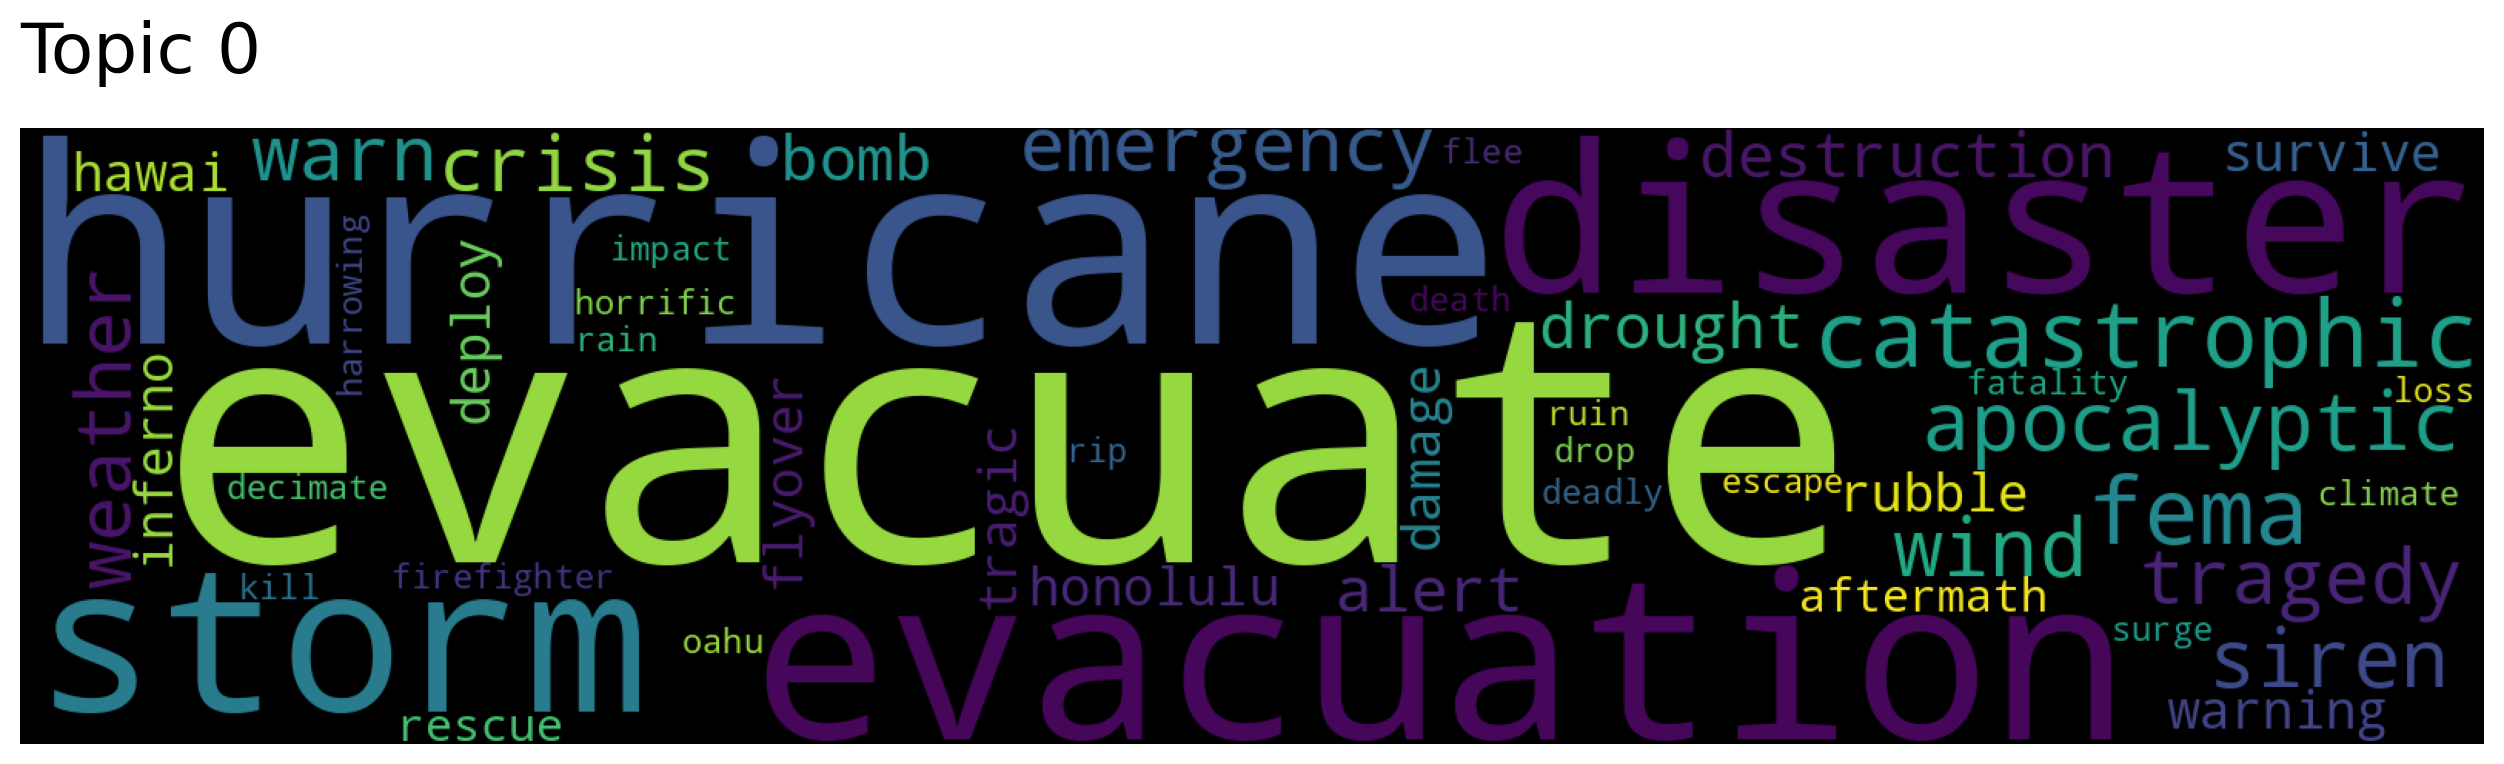

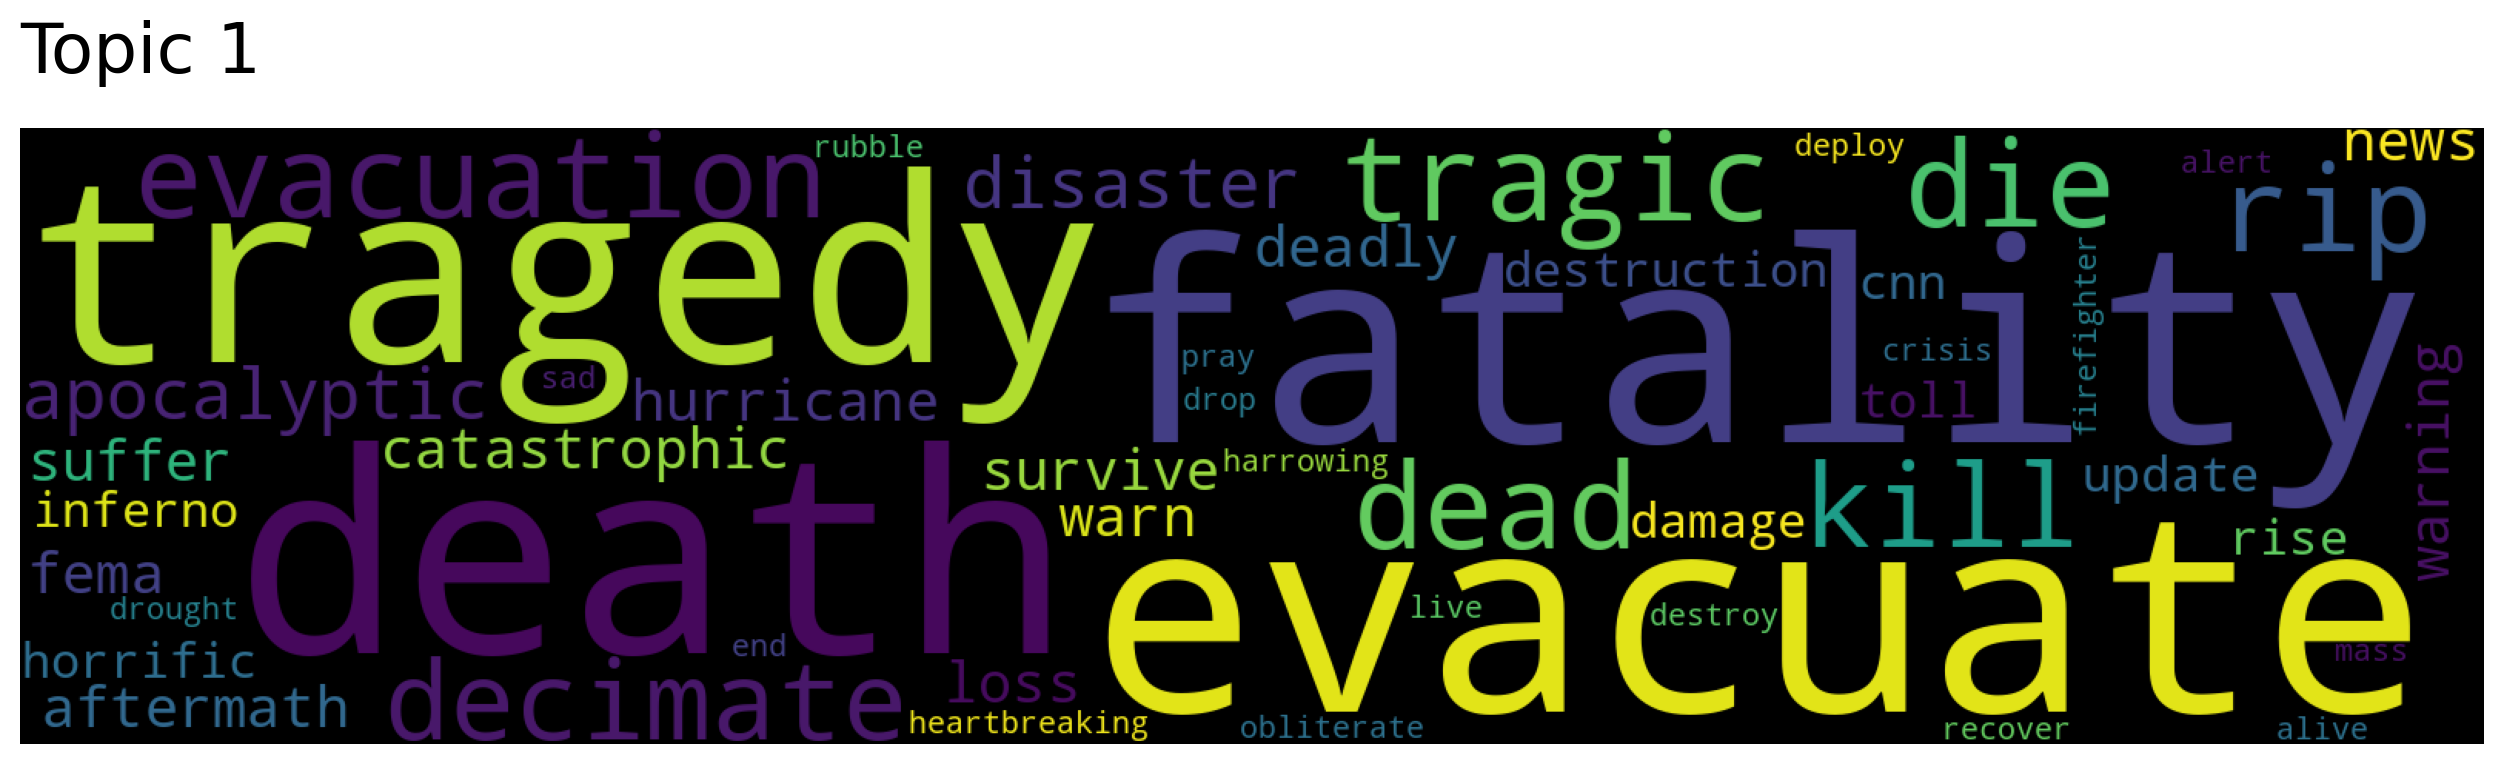

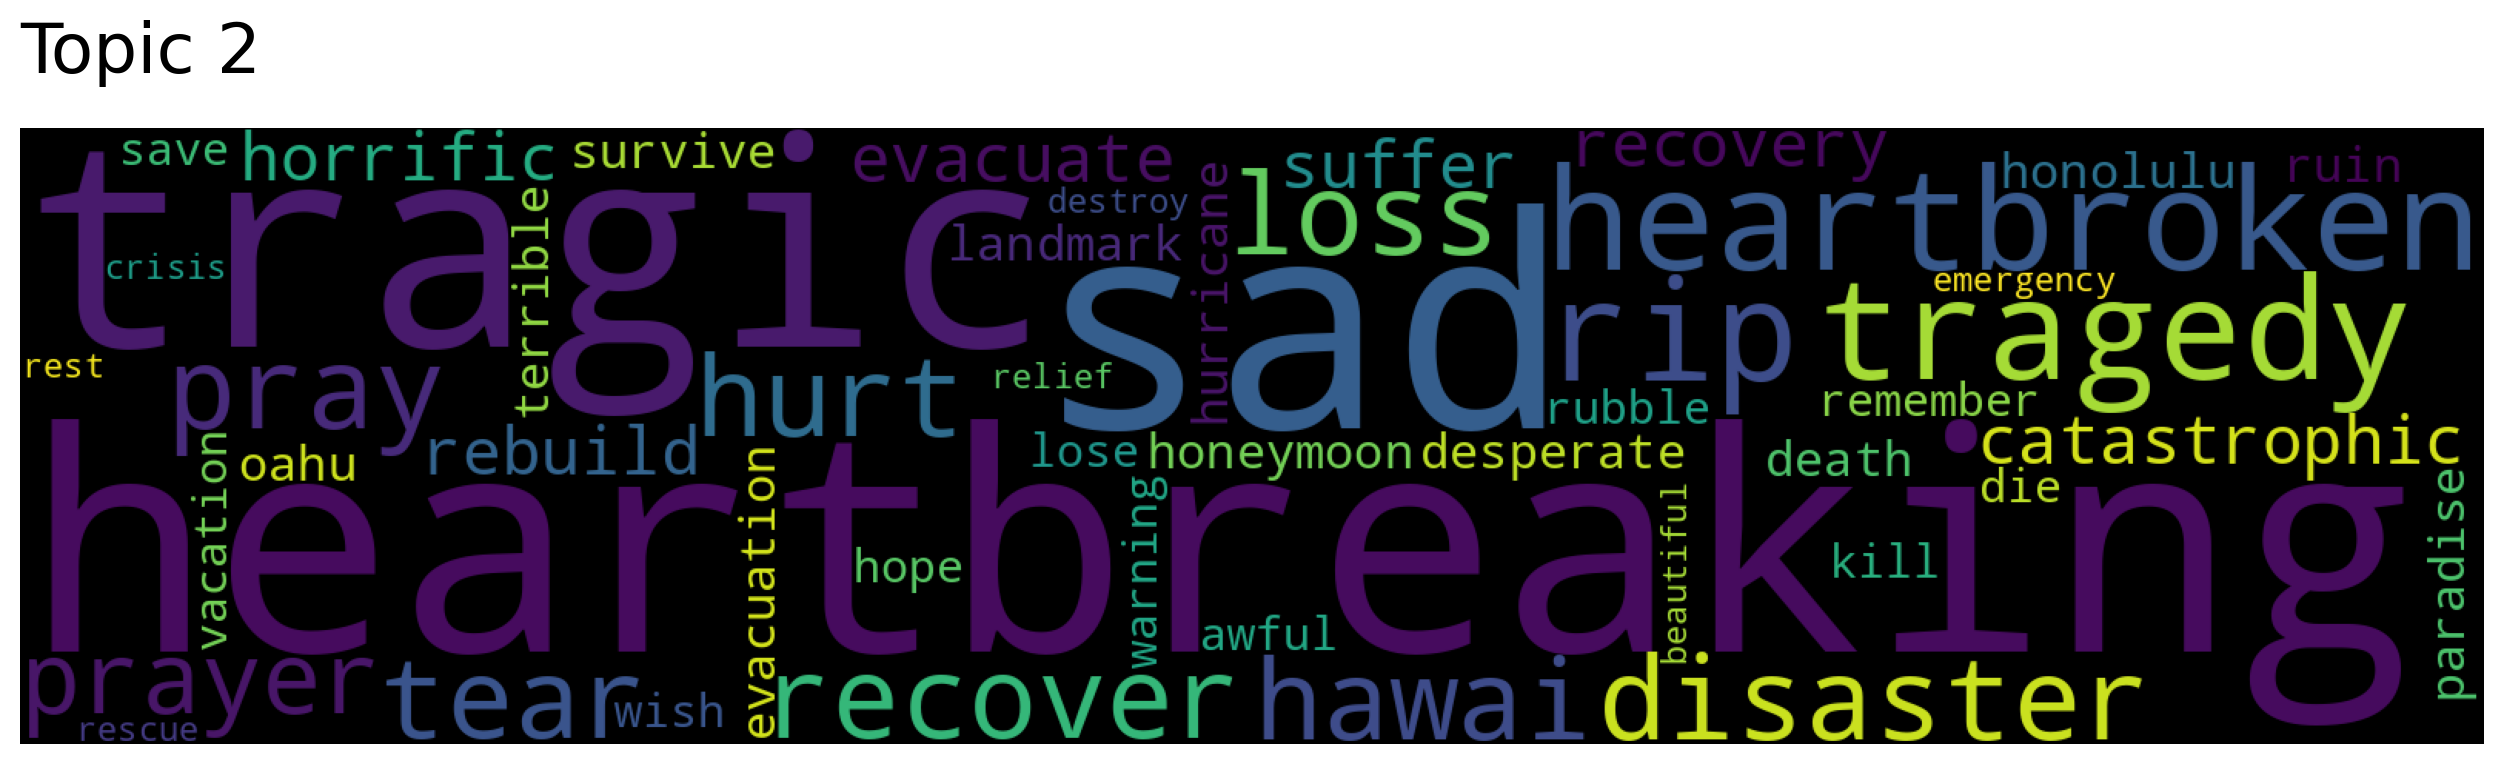

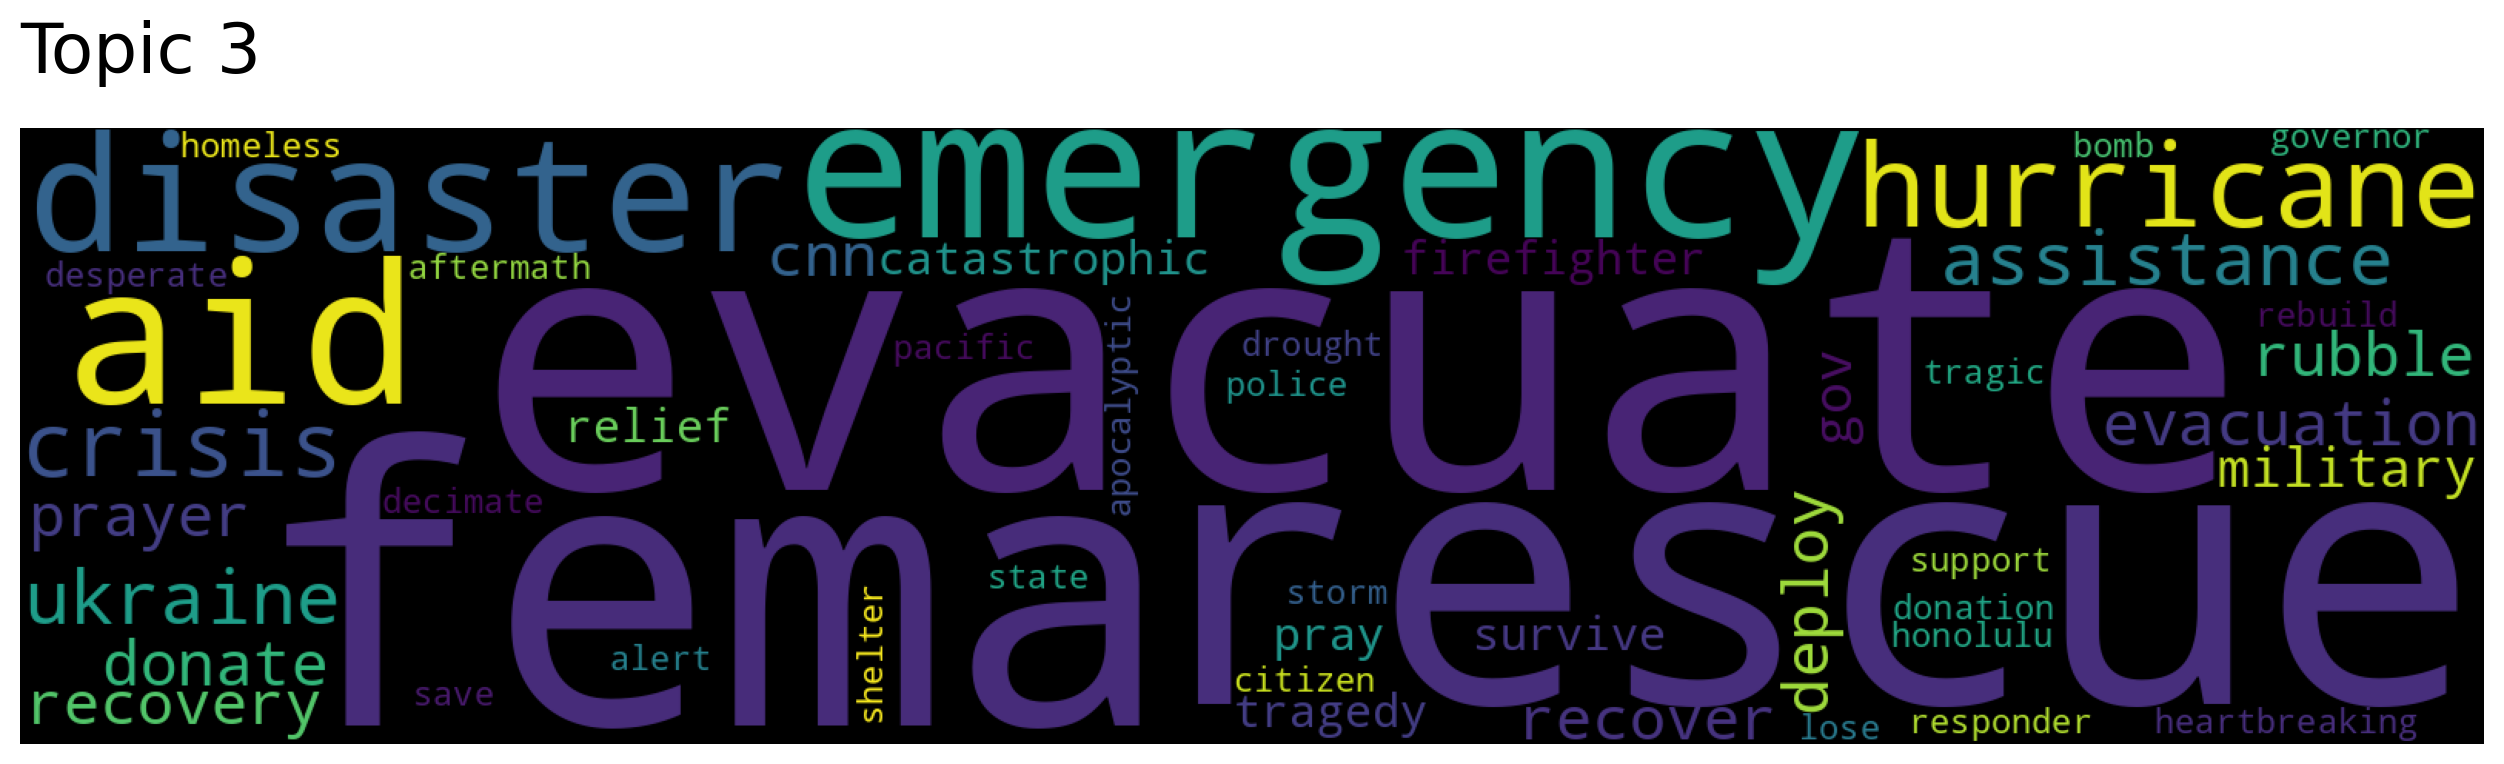

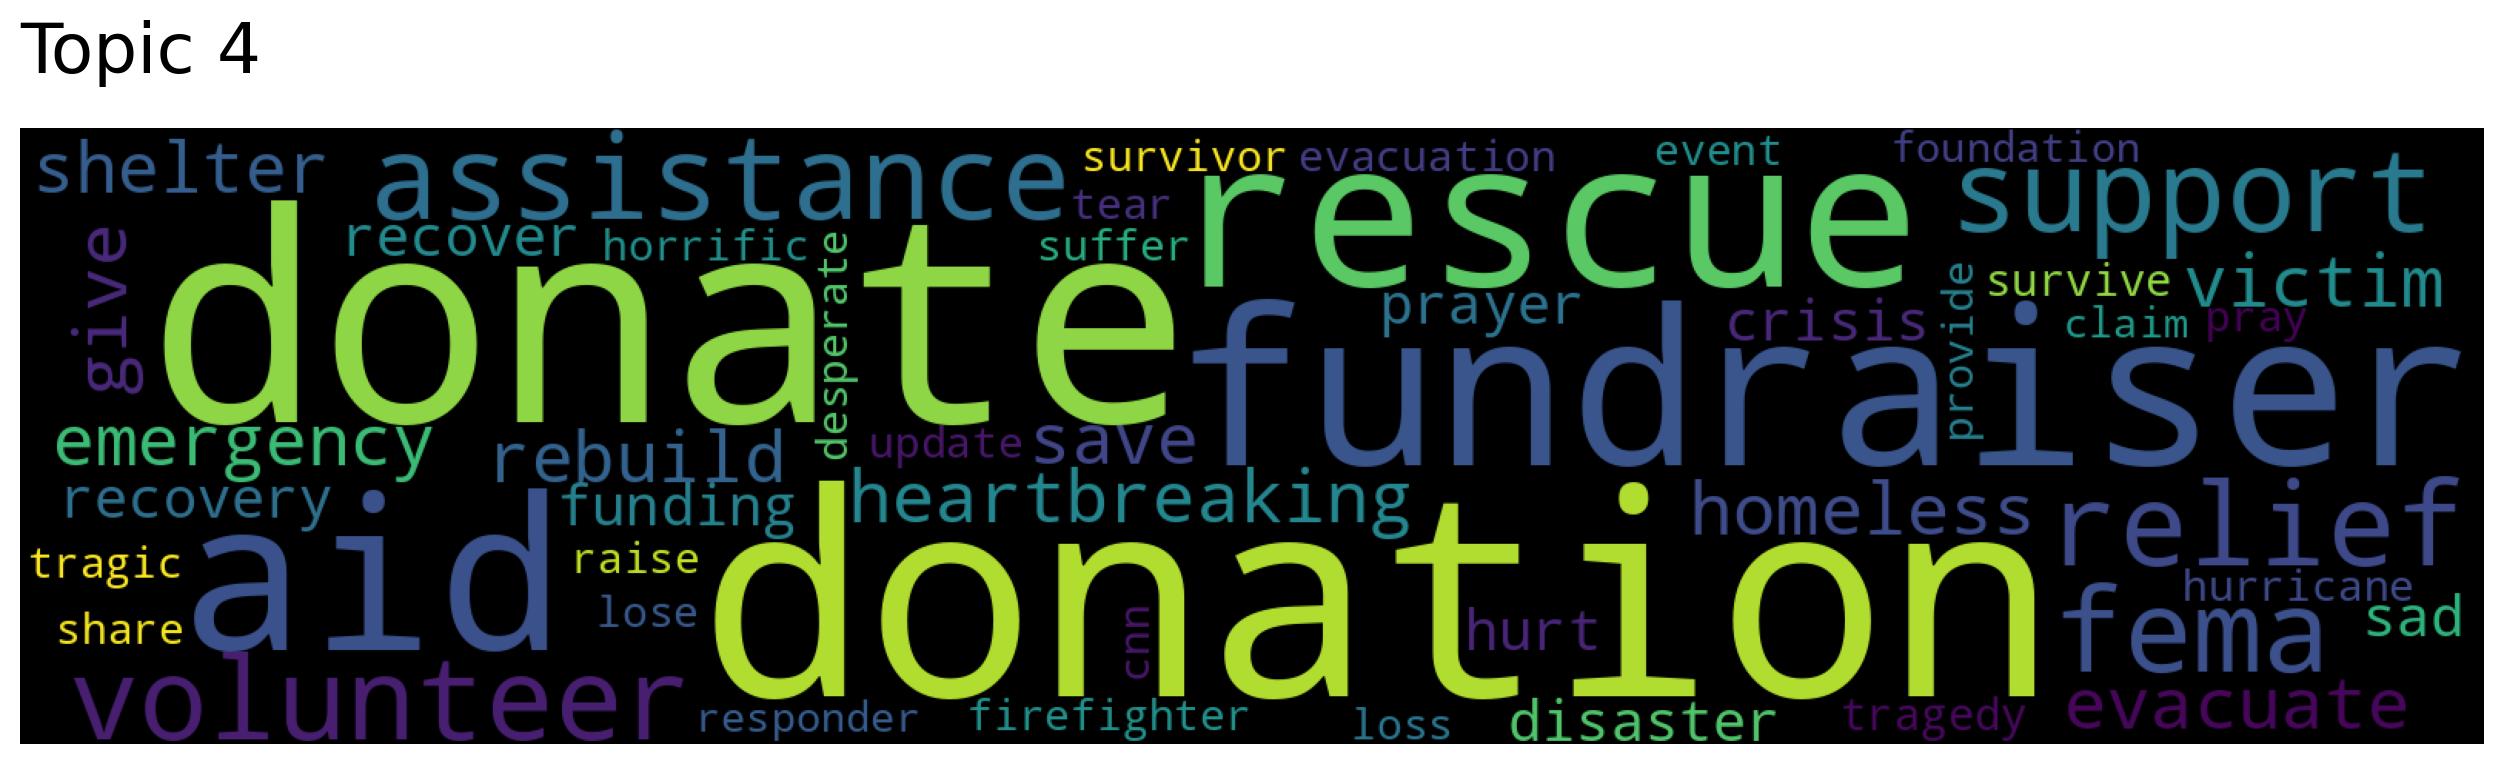

In [ ]:
# @title Default title text
topic_words, word_scores, topic_nums = model_all.get_topics()
for topic in topic_nums:
    model_all.generate_topic_wordcloud(topic)

### Results of the above model - if required

In [ ]:
word_count = 15

topic_words, word_scores, topic_nums = model_all.get_topics()

In [ ]:
res_df = pd.DataFrame(columns = ['Original_Tweets','Document', 'Topic', 'Score', 'Words - Freq','All_topics', 'umap-x', 'umap-y'])
res_df['Original_Tweets'] = df.FormattedHitSentence.tolist()
res_df['Document'] = df.Initial_conv_preprocessed.tolist()
res_df['Topic'] = model_all.doc_top
res_df['Score'] = model_all.doc_dist
res_df['All_topics'] = tuple(model_all.doc_dist_all_ordered)
res_df['umap-x'] = umap_embedding[:, 0]
res_df['umap-y'] = umap_embedding[:, 1]

for i, row in res_df.iterrows():
    print(i)
    print(f"Document: {i}", end='\r', flush=True)
    top = res_df.loc[i, :]['Topic']
    res_df.loc[i, 'Words - Freq'] =  str(tuple(topic_words[top][:word_count]))

res_df

In [ ]:
res_df

Original_Tweets  \
0      Questions Raised Over Warnings in Maui Wildfir...   
1      As death toll from Maui fire reaches 93, autho...   
2      As death toll from Maui fire reaches 93, autho...   
3      Lost in the complete devastation that these fi...   
4      As death toll from Maui fire reaches 93, autho...   
...                                                  ...   
14538   SHELTERS (Includes non-county) Kahului: *Maui...   
14539    We left Lahaina earlier this afternoon on a ...   
14540    I'm in Honolulu, which is on O‘ahu -- differ...   
14541  Buy Verified Transferwise Account ✅ Email: smm...   
14542   It's pretty bad in Lahaina! 😭 https://t.co/bx...   

                                                Document  Topic     Score  \
0      question raise warning   small woke country mn...     11  0.360577   
1      death toll reach authority effort count loss s...      6  0.629723   
2      death toll reach authority effort count loss s...      6  0.629723   
3      lose complete cause   eastern pacific see spri...     21  0.537090   
4      death toll reach authority effort count loss s...      6  0.629723   
...                                                  ...    ...       ...   
14538  shelter include non - county high school * kin...      5  0.241779   
14539  leave early afternoon vacuolation tell cell se...      1  0.667423   
14540  honolulu o'ahu different island yeah totally s...     12  0.601582   
14541  buy verification transferwise account   email ...     49  0.206188   
14542                                       pretty bad       14  0.641325   

                                            Words - Freq  \
0      ('evacuate', 'evacuation', 'fema', 'hurricane'...   
1      ('death', 'fatality', 'tragedy', 'tragic', 'de...   
2      ('death', 'fatality', 'tragedy', 'tragic', 'de...   
3      ('firefighter', 'blaze', 'inferno', 'scorch', ...   
4      ('death', 'fatality', 'tragedy', 'tragic', 'de...   
...                                                  ...   
14538  ('donate', 'donation', 'aid', 'fundraiser', 'a...   
14539  ('prayer', 'pray', 'heartbreaking', 'tragedy',...   
14540  ('escape', 'jump', 'ocean', 'evacuate', 'evacu...   
14541  ('ring', 'phone', 'call', 'desperate', 'search...   
14542  ('sad', 'heartbreaking', 'tragic', 'terrible',...   

                                              All_topics    umap-x     umap-y  
0      {52: 0.122009, 47: 0.22369501, 33: 0.06844957,...  2.018088   2.801505  
1      {52: 0.10753116, 47: 0.4884546, 33: 0.3371175,... -0.173395  21.523926  
2      {52: 0.10753116, 47: 0.4884546, 33: 0.3371175,... -0.161128  21.511673  
3      {52: 0.09088826, 47: 0.39411107, 33: 0.2400662...  4.183750   1.360744  
4      {52: 0.10753116, 47: 0.4884546, 33: 0.3371175,... -0.158611  21.509165  
...                                                  ...       ...        ...  
14538  {52: 0.04664061, 47: 0.019742642, 33: 0.089175...  1.578688  -0.337154  
14539  {52: 0.124843076, 47: 0.27064174, 33: 0.109212...  1.366670  -0.696566  
14540  {52: 0.072950475, 47: 0.3494931, 33: 0.0567111... -0.065826   0.312640  
14541  {52: 0.107063696, 47: -0.042176887, 33: 0.1065... -9.326900  -4.252753  
14542  {52: -0.017644826, 47: 0.109592944, 33: 0.0177...  1.208619  -3.008479  

[14543 rows x 8 columns]

In [ ]:
res_df.to_excel('res_intial_hawaii_large dataset_report2.xlsx', index=False)